# % Clientes que alcanzaron cada paso

La gráfica actual muestra el porcentaje de clientes que alcanzaron cada paso del proceso (es decir, la tasa de conversión en cada etapa). Con esa información puedes deducir el "drop-off" (la caída entre etapas) restando, por ejemplo, el porcentaje de clientes que llegaron a "step_1" del porcentaje que llegaron a "start", y así sucesivamente.

=== Funnel de Conversión a Nivel de Cliente (por paso) ===
variation    Control       Test
start      99.454758  99.050757
step_1     85.544340  90.103554
step_2     79.154650  82.533145
step_3     73.918529  77.312309
confirm    65.248738  68.949557


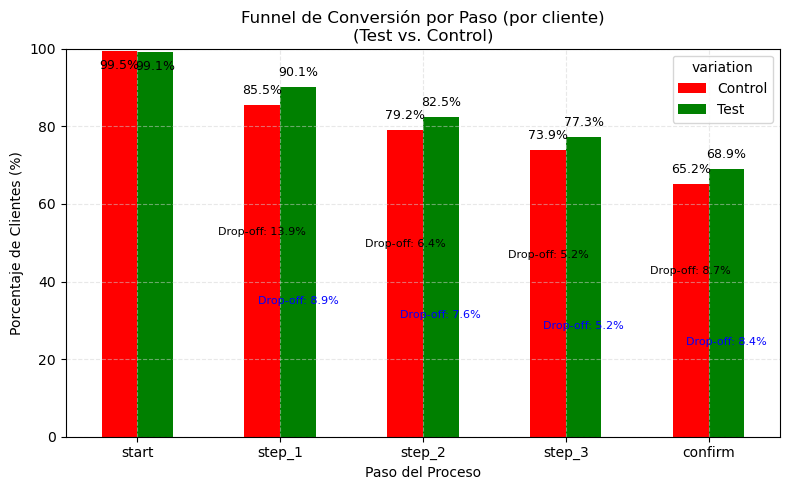


=== Drop-off entre Pasos (en %) ===
variation    Control      Test
start            NaN       NaN
step_1     13.910418  8.947203
step_2      6.389690  7.570409
step_3      5.236121  5.220836
confirm     8.669791  8.362752


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------
# PASO 1: Cargar el DataFrame ya procesado
# --------------------------------------------------
df = pd.read_csv("../../data/processed/navegacion_clientes_experimento_limpio.csv")
df = df[df["variation"].isin(["Test", "Control"])].copy()

# --------------------------------------------------
# PASO 2: Agrupar a nivel de cliente y construir el funnel
# --------------------------------------------------
steps = ["start", "step_1", "step_2", "step_3", "confirm"]

client_records = []
for (variation, client_id), group in df.groupby(["variation", "client_id"]):
    record = {"variation": variation, "client_id": client_id}
    for step in steps:
        record[step + "_reached"] = group["process_step"].eq(step).any()
    client_records.append(record)

df_clients = pd.DataFrame(client_records)

# --------------------------------------------------
# PASO 3: Calcular la tasa de conversión (CR) por paso (en %)
# --------------------------------------------------
funnel_data = {}
for step in steps:
    col = step + "_reached"
    prop = df_clients.groupby("variation")[col].mean() * 100  # porcentaje
    funnel_data[step] = prop

funnel_df = pd.DataFrame(funnel_data).T
funnel_df = funnel_df.reindex(steps)
funnel_df = funnel_df[["Control", "Test"]]

print("=== Funnel de Conversión a Nivel de Cliente (por paso) ===")
print(funnel_df)

# --------------------------------------------------
# PASO 4: Calcular el drop-off entre pasos
# --------------------------------------------------
drop_off_df = funnel_df.shift(1) - funnel_df  # diferencia con el paso anterior

# --------------------------------------------------
# PASO 5: Graficar el funnel de conversión y anotar conversion y drop-off
# --------------------------------------------------
color_map = {"Control": "red", "Test": "green"}
annot_color = {"Control": "black", "Test": "blue"}

fig, ax = plt.subplots(figsize=(8, 5))
funnel_df.plot(kind="bar", ax=ax, color=[color_map.get(col, "gray") for col in funnel_df.columns], legend=True)

ax.set_title("Funnel de Conversión por Paso (por cliente)\n(Test vs. Control)")
ax.set_xlabel("Paso del Proceso")
ax.set_ylabel("Porcentaje de Clientes (%)")
ax.set_ylim(0, 100)
ax.grid(True, which="major", axis="both", color="lightgray", linestyle="--", alpha=0.5)

# --------------------------------------------------
# PASO 6: Anotar el % de conversión sobre cada barra (conversion rate)
# --------------------------------------------------
for rect in ax.patches:
    height = rect.get_height()
    if not np.isnan(height):
        x = rect.get_x() + rect.get_width() / 2
        # Si la barra está muy alta (por ejemplo, >=95%), ubicamos la etiqueta dentro de la barra
        if height >= 95:
            y = rect.get_y() + height - 2  # dentro de la barra
            label_color = "black"
            va_setting = "top"
        else:
            y = rect.get_y() + height + 2  # por encima de la barra
            label_color = "black"
            va_setting = "bottom"
        ax.annotate(f"{height:.1f}%", (x, y), ha="center", va=va_setting, fontsize=9, color=label_color)

# --------------------------------------------------
# PASO 7: Anotar los valores de drop-off en cada barra
# --------------------------------------------------
# Usaremos un offset vertical distinto para cada grupo para evitar solapamientos.
offsets = {"Test": -10, "Control": 10}  # Ajusta estos valores según convenga
for container, variation in zip(ax.containers, funnel_df.columns):
    for i, rect in enumerate(container):
        if i == 0:
            continue  # No hay drop-off para el primer paso
        drop_value = drop_off_df.loc[funnel_df.index[i], variation]
        if pd.notna(drop_value) and drop_value > 0:
            # Colocar la etiqueta en el centro vertical de la barra con offset
            x = rect.get_x() + rect.get_width() / 2
            y = rect.get_y() + rect.get_height() / 2 + offsets.get(variation, 0)
            ax.annotate(f"Drop-off: {drop_value:.1f}%",
                        (x, y),
                        ha="center", va="center", fontsize=8, color=annot_color.get(variation, "blue"))

plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("../../img/cr_drop-off_funnel.png", dpi=300, bbox_inches='tight')
plt.show()

# Print the drop-off data
print("\n=== Drop-off entre Pasos (en %) ===")
print(drop_off_df)

